In [1]:
# useful to reload automatically a module if its code has been modified 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys 
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import find_contours
from scipy.ndimage.filters import gaussian_filter
import eikonalfm as fm

from sources.utils import read_mri, extract_curve

### Read data for selected patient

In [3]:
# read dataframe
image_df = pd.read_csv('image_data.csv')

# choose a patient
patient_index = 0
patient_id = image_df.patient_id.unique()[patient_index]

# read mri
image_stack, mask_stack, has_tumor_indices = read_mri(image_df, patient_id)

print("Patient ID : ", patient_id)
print("MRI stack : shape =", image_stack.shape, ", dtype =", image_stack.dtype)
print("Mask stack : shape =", mask_stack.shape, ", dtype =", mask_stack.dtype)
print("Indices of slices with segmented tumor :", has_tumor_indices)

Patient ID :  TCGA_CS_4941_19960909
MRI stack : shape = (23, 256, 256, 3) , dtype = uint8
Mask stack : shape = (23, 256, 256) , dtype = uint8
Indices of slices with segmented tumor : [10, 11, 12, 13, 14, 15, 16, 17]


### Click on points around the tumor

<IPython.core.display.Javascript object>


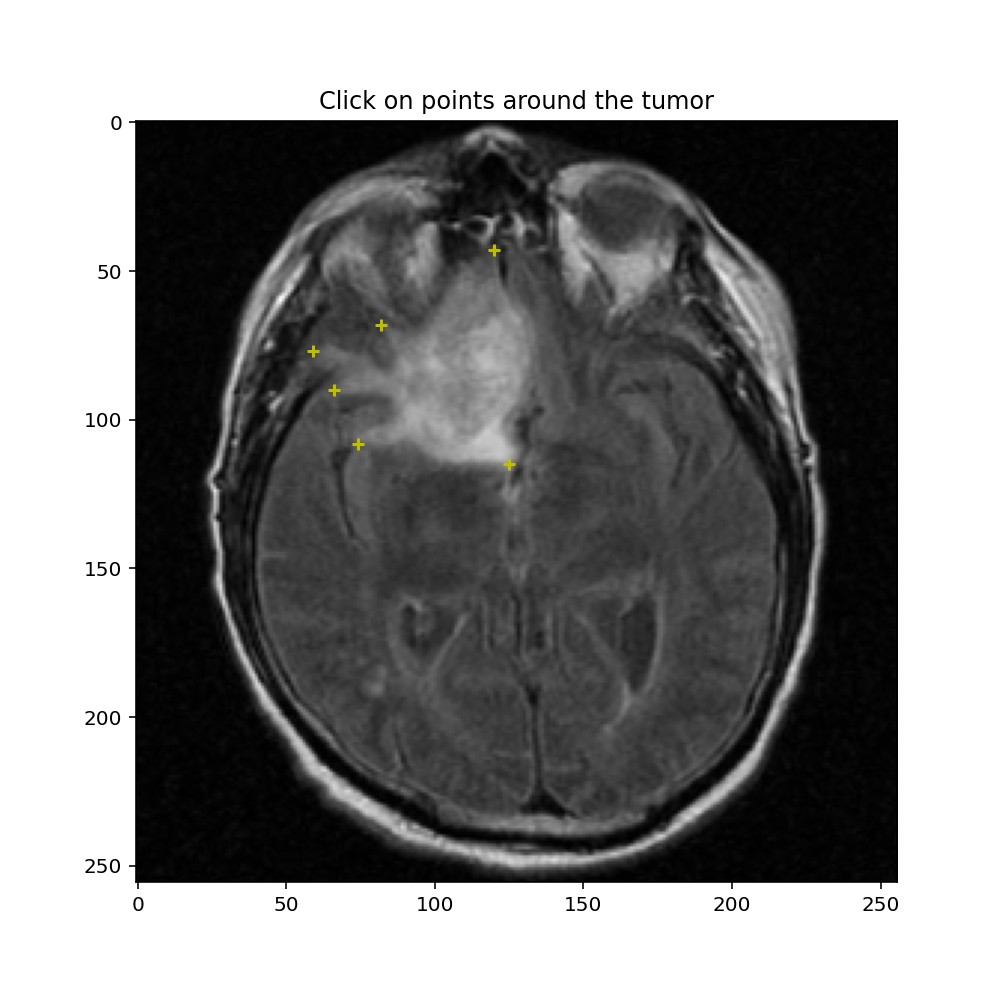

In [6]:
%matplotlib notebook  

# select slice with non-empty tumor mask
slice_index = 11
img = image_stack[slice_index, :, :, 1].astype('float')/255

# interactive plot : click on points
fig = plt.figure(figsize=(7, 7))

points = []
def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    points.append([event.ydata, event.xdata])
    plt.scatter(int(event.xdata), int(event.ydata), marker='+', c='y')
    
plt.imshow(img, 'gray')
plt.title("Click on points around the tumor")

cid = fig.canvas.mpl_connect('button_press_event', onclick)


### Fast-Marching computation

Running time : 0.13


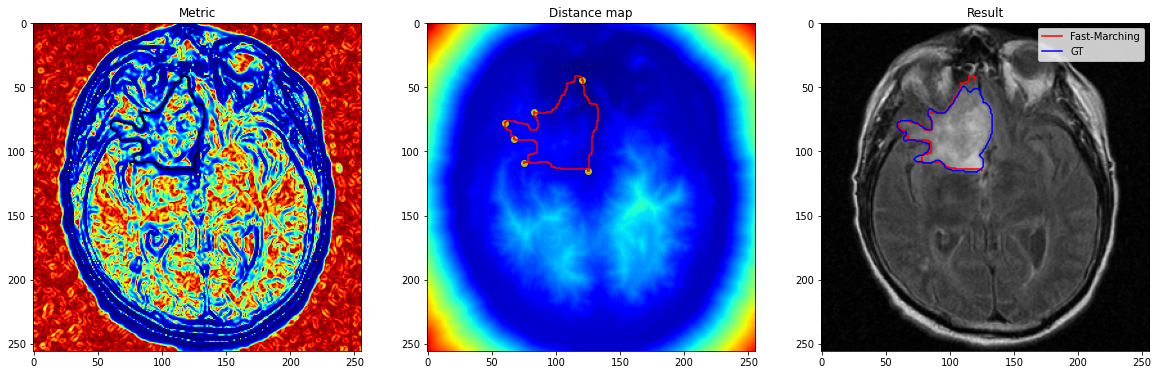

In [9]:
%matplotlib inline 

# convert points to int
points = np.round(points).astype('int')

# design gradient-based metric
gauss = gaussian_filter(img, 1)
gx = np.gradient(gauss, axis=0)
gy = np.gradient(gauss, axis=1)
metric = 1/(1e-4 + gx ** 2 + gy ** 2)

# run fast-marching 
start = time.time()
curves = []
for i in range(len(points)-1):
    dist_map = fm.fast_marching(1/metric, points[i], (1, 1), 2)
    curves.append(extract_curve(dist_map, points[i+1]))
dist_map = fm.fast_marching(1/metric, points[-1], (1, 1), 2)
curves.append(extract_curve(dist_map, points[0]))
print("Running time : {:.2f}".format(time.time()-start))

# display result
fig = plt.figure(figsize=(20, 10))

plt.subplot(131), plt.imshow(metric, 'jet'), plt.title('Metric')
for c in curves:
    plt.plot(c[:, 1], c[:, 0], c='black')
    
plt.subplot(132), plt.imshow(dist_map, 'jet'), plt.title('Distance map')
for c in curves:
    plt.plot(c[:, 1], c[:, 0], c='r')
plt.scatter(points[:, 1], points[:, 0], c='y')

plt.subplot(133), plt.imshow(img, 'gray'), plt.title('Result')
for c in curves[:-1]:
    plt.plot(c[:, 1], c[:, 0], c='r')
plt.plot(c[-1, 1], c[-1, 0], c='r', label='Fast-Marching')
contours = find_contours(mask_stack[slice_index], 1)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], c='b', label='GT')
plt.legend()
plt.show()